In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/multiclass-weather-dataset/dataset/test.csv
/kaggle/input/multiclass-weather-dataset/dataset/cloudy/cloudy88.jpg
/kaggle/input/multiclass-weather-dataset/dataset/cloudy/cloudy167.jpg
/kaggle/input/multiclass-weather-dataset/dataset/cloudy/cloudy78.jpg
/kaggle/input/multiclass-weather-dataset/dataset/cloudy/cloudy80.jpg
/kaggle/input/multiclass-weather-dataset/dataset/cloudy/cloudy2.jpg
/kaggle/input/multiclass-weather-dataset/dataset/cloudy/cloudy89.jpg
/kaggle/input/multiclass-weather-dataset/dataset/cloudy/cloudy99.jpg
/kaggle/input/multiclass-weather-dataset/dataset/cloudy/cloudy256.jpg
/kaggle/input/multiclass-weather-dataset/dataset/cloudy/cloudy9.jpg
/kaggle/input/multiclass-weather-dataset/dataset/cloudy/cloudy185.jpg
/kaggle/input/multiclass-weather-dataset/dataset/cloudy/cloudy208.jpg
/kaggle/input/multiclass-weather-dataset/dataset/cloudy/cloudy44.jpg
/kaggle/input/multiclass-weather-dataset/dataset/cloudy/cloudy269.jpg
/kaggle/input/multiclass-weather-dataset/d

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
import random
from tensorflow.keras import layers, models, Input
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split
import tqdm as tqdm


In [3]:
root_dir = "/kaggle/input/multiclass-weather-dataset/dataset/"
os.listdir(root_dir)

['cloudy', 'sunrise', 'alien_test', 'shine', 'test.csv', 'foggy', 'rainy']

In [4]:
foggy = "/kaggle/input/multiclass-weather-dataset/dataset/foggy"
sunrise = "/kaggle/input/multiclass-weather-dataset/dataset/sunrise"
shine = "/kaggle/input/multiclass-weather-dataset/dataset/shine"
rainy = "/kaggle/input/multiclass-weather-dataset/dataset/rainy"
cloudy = "/kaggle/input/multiclass-weather-dataset/dataset/cloudy"
#test = "/kaggle/input/multiclass-weather-dataset/dataset/alien_test"

In [5]:
print("Number of Images in Each Directory:")
print(f"Foggy: {len(os.listdir(foggy))}")
print(f"Sunrise: {len(os.listdir(sunrise))}")
print(f"Shine: {len(os.listdir(shine))}")
print(f"Rainy: {len(os.listdir(rainy))}")
print(f"Cloudy: {len(os.listdir(cloudy))}")

Number of Images in Each Directory:
Foggy: 300
Sunrise: 350
Shine: 250
Rainy: 300
Cloudy: 300


Data preprocessing 

In [6]:
x = []
y = [] 
dataset =[]
def create_dataset(directory,dir_name):
    for i in tqdm.tqdm(os.listdir(directory)):
        full_path = os.path.join(directory,i)
        try:
            img = cv2.imread(full_path)
            img = cv2.resize(img,(224,224))
        except:
            continue
        x.append(img)
        y.append(dir_name)
    return x,y

In [7]:
x,y= create_dataset(foggy,"foggy")
x,y= create_dataset(sunrise,"sunrise")
x,y= create_dataset(shine,"shine")
x,y= create_dataset(rainy,"rainy")
x,y= create_dataset(cloudy,"cloudy")

100%|██████████| 300/300 [00:02<00:00, 113.47it/s]


In [8]:
x =  np.array(x)
y = np.array(y)
x.shape,y.shape

((1498, 224, 224, 3), (1498,))

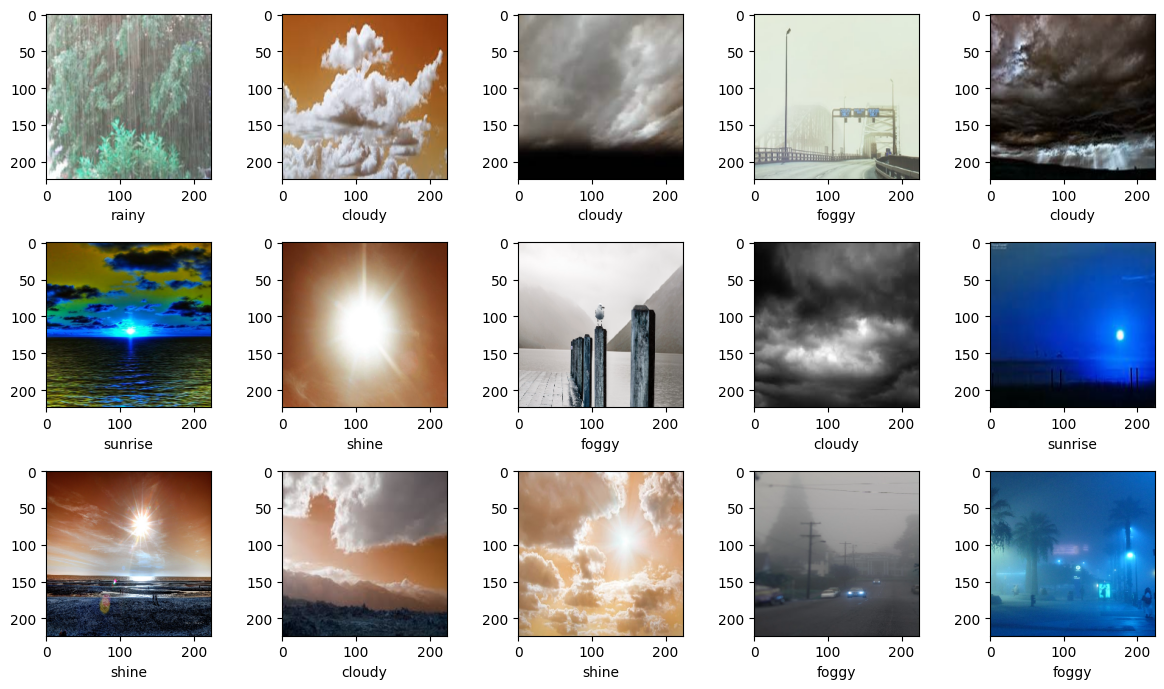

In [9]:
fig = plt.figure(figsize=(12,7))
for i in range(15):
    sample =  random.choice(range(len(x)))
    image = x[sample]
    category = y[sample]
    plt.subplot(3,5,i+1)
    plt.subplots_adjust(hspace=0.3)
    plt.imshow(image)
    plt.xlabel(category)
    
plt.tight_layout()
plt.show()

In [10]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

In [11]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [12]:
x_train_resized = np.array([cv2.resize(img, (224, 224)) for img in x_train])  # تغيير حجم الصور
x_test_resized = np.array([cv2.resize(img, (224, 224)) for img in x_test])

# تطبيع البيانات
x_train_resized = x_train_resized / 255.0
x_test_resized = x_test_resized / 255.0

# تغيير شكل المدخلات لتكون 3 قنوات
x_train_resized = x_train_resized.reshape(-1, 224, 224, 3)
x_test_resized = x_test_resized.reshape(-1, 224, 224, 3)

# تحويل التسميات إلى تمثيلات one-hot
lb = LabelBinarizer()
y_train_lb = lb.fit_transform(y_train)
y_test_lb = lb.fit_transform(y_test)


In [13]:
y_train_lb.shape,y_test_lb.shape

((1198, 5), (300, 5))

Build the model

In [14]:
input_size = x.shape[1]
output_size = 5

In [15]:
from tensorflow.keras import layers, models, Input

def residual_block(x, filters, s=1):

    x_shortcut = x

    # First layer
    x = layers.Conv2D(filters, (3, 3), strides=(s, s), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Second layer
    x = layers.Conv2D(filters, (3, 3), strides=(1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Adjust shortcut for stride mismatch
    if s != 1 or x_shortcut.shape[-1] != filters:
        x_shortcut = layers.Conv2D(filters, (1, 1), strides=(s, s))(x_shortcut)
        x_shortcut = layers.BatchNormalization()(x_shortcut)

    # Add shortcut
    x = layers.Add()([x, x_shortcut])
    x = layers.ReLU()(x)

    return x

def ResNet18(input_shape, classes):

    x_input = Input(input_shape)

    # Initial convolution and max pooling
    x = layers.ZeroPadding2D((3, 3))(x_input)
    x = layers.Conv2D(64, (7, 7), strides=(2, 2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Residual blocks
    x = residual_block(x, 64, s=1)
    x = residual_block(x, 64, s=1)

    x = residual_block(x, 128, s=2)
    x = residual_block(x, 128, s=1)

    x = residual_block(x, 256, s=2)
    x = residual_block(x, 256, s=1)

    x = residual_block(x, 512, s=2)
    x = residual_block(x, 512, s=1)

    # Global average pooling and output layer
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(classes, activation='softmax')(x)

    model = models.Model(inputs=x_input, outputs=x)
    return model

# Model instantiation
input_shape = (224, 224, 3)
resnet18_model = ResNet18(input_shape=input_shape, classes=5)

# Compile the model
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)
resnet18_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary to verify
resnet18_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      9,472 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 56,    │     36,928 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │     36,928 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 56, 56,    │          0 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 56, 56,    │     36,928 │ re_lu_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │     36,928 │ re_lu_3[0][0]   

 Total params: 11,193,477 (42.70 MB)

 Trainable params: 11,183,877 (42.66 MB)

 Non-trainable params: 9,600 (37.50 KB)

In [16]:
from tensorflow.keras.callbacks import EarlyStopping

# إعداد الـ EarlyStopping: يتوقف التدريب عندما لا يتحسن الـ validation_loss بعد 5 epochs
early_stopping = EarlyStopping(
    monitor='val_loss',   # يمكن تغييرها إلى 'val_accuracy' إذا كنت تفضل مراقبة الدقة
    patience=15,           # عدد الـ epochs التي سيتم انتظارها قبل التوقف
    verbose=1,            # لعرض رسائل عند التوقف المبكر
    restore_best_weights=True  # لإعادة الوزن الأفضل عند التوقف المبكر
)

# تدريب النموذج مع إضافة الـ EarlyStopping
history = resnet18_model.fit(
    x_train_resized, y_train_lb, 
    epochs=100, 
    batch_size=64, 
    validation_data=(x_test_resized, y_test_lb),
    callbacks=[early_stopping]  # إضافة الـ EarlyStopping هنا
)



Epoch 1/100


I0000 00:00:1734521308.205588      98 service.cc:145] XLA service 0x7982e0003160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734521308.205645      98 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 1/19 ━━━━━━━━━━━━━━━━━━━━ 6:26 21s/step - accuracy: 0.1875 - loss: 2.2459

I0000 00:00:1734521319.495103      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


19/19 ━━━━━━━━━━━━━━━━━━━━ 36s 808ms/step - accuracy: 0.4595 - loss: 2.0609 - val_accuracy: 0.2267 - val_loss: 1473.1926
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.7656 - loss: 0.6646 - val_accuracy: 0.2267 - val_loss: 184.9395
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.8022 - loss: 0.5242 - val_accuracy: 0.2367 - val_loss: 24.6626
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.8270 - loss: 0.4952 - val_accuracy: 0.3933 - val_loss: 17.8471
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.8458 - loss: 0.4384 - val_accuracy: 0.3833 - val_loss: 2.6947
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.8436 - loss: 0.4264 - val_accuracy: 0.2067 - val_loss: 4.2091
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.8833 - loss: 0.3440 - val_accuracy: 0.3900 - val_loss: 2.4838
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.8607 - loss: 0.3779 - val_accuracy

In [17]:
test_loss, test_acc = resnet18_model.evaluate( x_train_resized, y_train_lb, verbose=2)
print(f"Train accuracy: {test_acc}")

test_loss, test_acc = resnet18_model.evaluate(x_test_resized, y_test_lb, verbose=2)
print(f"Test accuracy: {test_acc}")


38/38 - 4s - 95ms/step - accuracy: 0.9257 - loss: 0.2201
Train accuracy: 0.9257095456123352
10/10 - 1s - 148ms/step - accuracy: 0.9000 - loss: 0.4296
Test accuracy: 0.8999999761581421


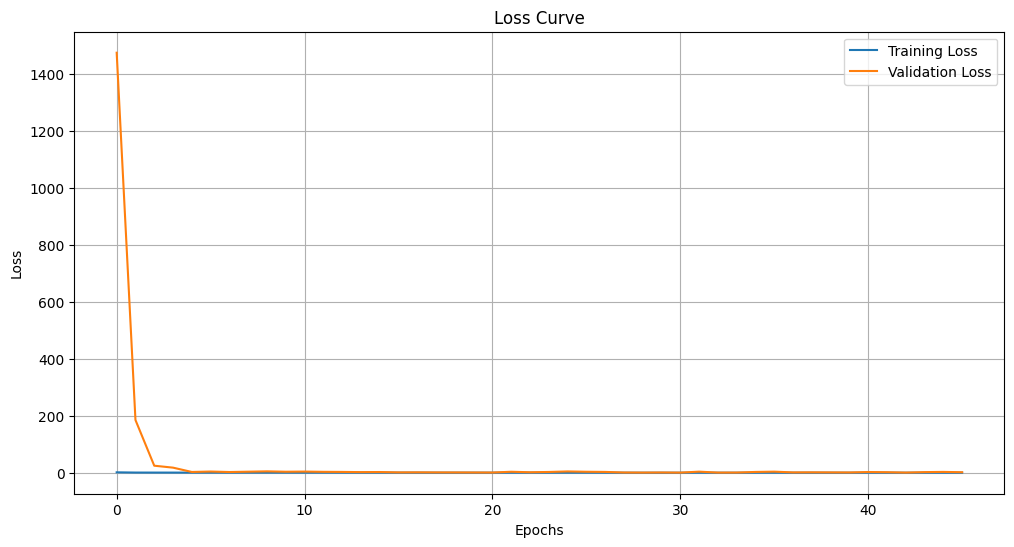

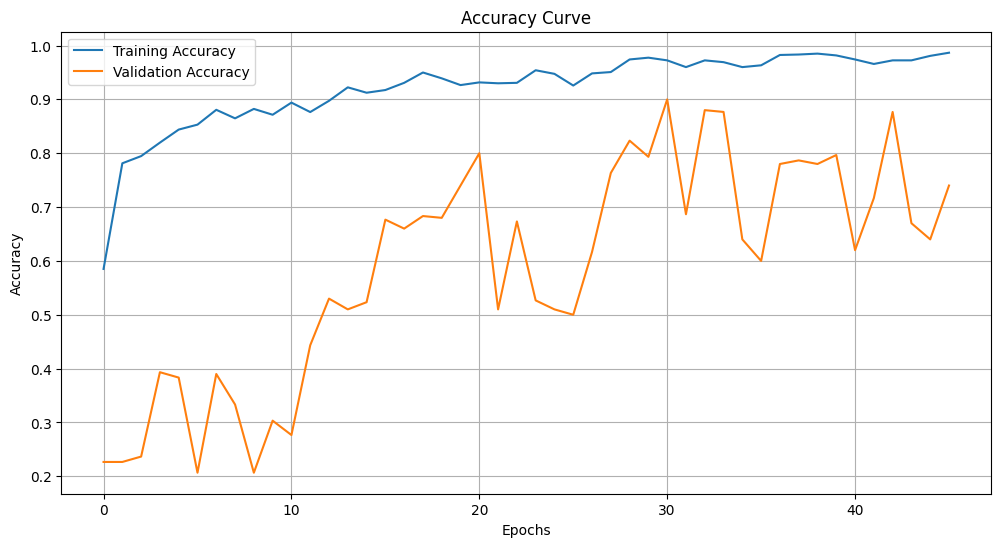

In [18]:

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

import matplotlib.pyplot as plt

# Plot loss
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# التنبؤ بالتصنيفات على مجموعة الاختبار
y_pred = resnet18_model.predict(x_test_resized)
y_pred_classes = np.argmax(y_pred, axis=1)  # الحصول على الفئة المتوقعة من الاحتمالات

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step


In [20]:

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred_classes)
print(f"Accuracy on test set: {accuracy * 100:.2f}%")

Accuracy on test set: 90.00%


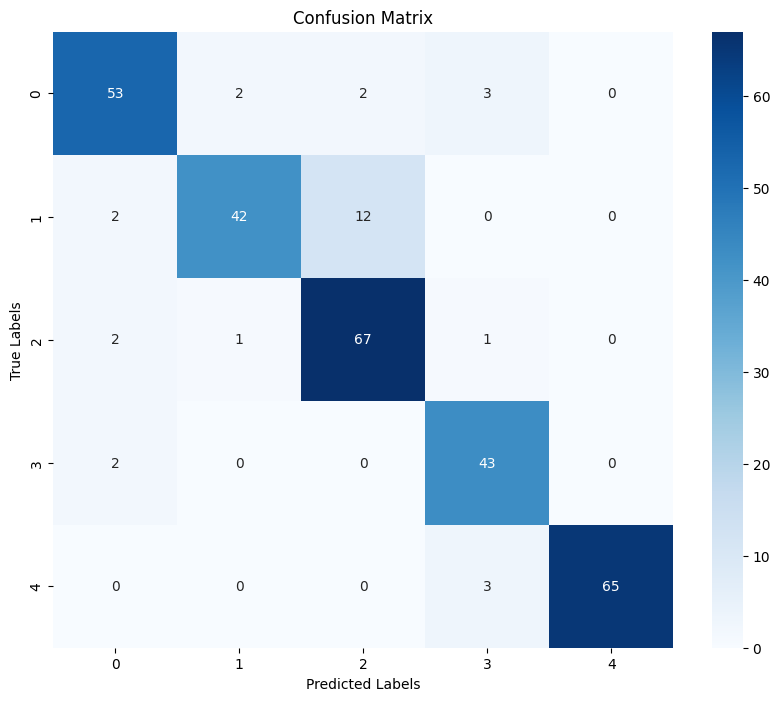

In [21]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# رسم مصفوفة الالتباس
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [22]:
# تعريف أسماء الفئات
target_names = ["Foggy", "Rainy", "Cloudy", "Sunrise", "Shine"]  # أو أي أسماء فئات أخرى لديك

# تقرير التصنيف
class_report = classification_report(y_test, y_pred_classes, target_names=target_names, output_dict=True)
print("Classification Report:\n", class_report)


Classification Report:
 {'Foggy': {'precision': 0.8983050847457628, 'recall': 0.8833333333333333, 'f1-score': 0.8907563025210085, 'support': 60}, 'Rainy': {'precision': 0.9333333333333333, 'recall': 0.75, 'f1-score': 0.8316831683168316, 'support': 56}, 'Cloudy': {'precision': 0.8271604938271605, 'recall': 0.9436619718309859, 'f1-score': 0.8815789473684211, 'support': 71}, 'Sunrise': {'precision': 0.86, 'recall': 0.9555555555555556, 'f1-score': 0.9052631578947369, 'support': 45}, 'Shine': {'precision': 1.0, 'recall': 0.9558823529411765, 'f1-score': 0.9774436090225563, 'support': 68}, 'accuracy': 0.9, 'macro avg': {'precision': 0.9037597823812513, 'recall': 0.8976866427322102, 'f1-score': 0.8973450370247109, 'support': 300}, 'weighted avg': {'precision': 0.9053112227104695, 'recall': 0.9, 'f1-score': 0.8993824945298599, 'support': 300}}


In [23]:
# Precision, Recall, F1 Score for each class
precision = class_report['accuracy']
recall = class_report['macro avg']['recall']
f1_score = class_report['macro avg']['f1-score']
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")

Precision: 0.9
Recall: 0.8976866427322102
F1 Score: 0.8973450370247109


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


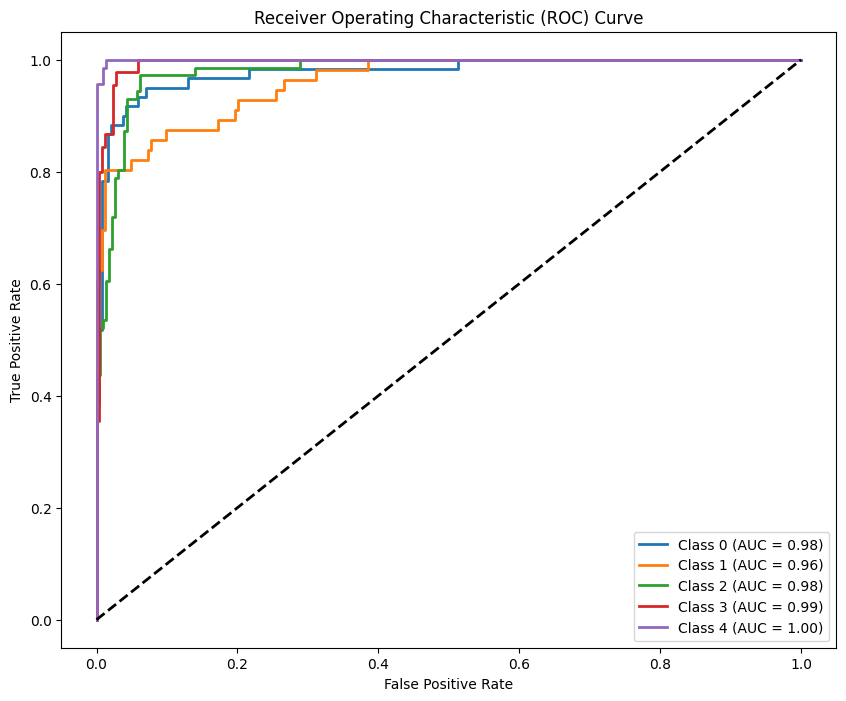

In [25]:
# رسم منحنى ROC و AUC
y_test_bin = lb.transform(y_test)
y_pred_prob = resnet18_model.predict(x_test_resized)
plt.figure(figsize=(10, 8))
for i in range(5):
    fpr, tpr, thresholds = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [26]:
# حساب AUC للموديل
average_auc = np.mean([auc(roc_curve(y_test_bin[:, i], y_pred_prob[:, i])[0], roc_curve(y_test_bin[:, i], y_pred_prob[:, i])[1]) for i in range(5)])
print(f'Average AUC Score: {average_auc:.2f}')

Average AUC Score: 0.98


In [28]:
# Save the entire model
resnet18_model.save('/kaggle/working/resnet18_model.h5')
